## Deep Learning & Image Classification Setup
### Importing Libraries 

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import sklearn
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

## Dataset Paths and Directory Setup

In [6]:
images_dir = "/kaggle/input/skin-dataset/skin/HAM10000_data"
csv_path = "/kaggle/input//skin-dataset/skin/HAM10000_metadata.csv"
data_images_dir='/kaggle/working/Images'
data_images_tmp='/kaggle/working/tmp'


## Hair Removal & Image Preprocessing
### To improve model performance on dermatoscopic images, this script removes hair artifacts using OpenCV techniques before saving the cleaned images to a temporary directory.

In [7]:
def preprocess(image):
    try:
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
        _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
        gaussian = cv2.GaussianBlur(final_image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
        return final_image
    except Exception as e:
        print(f"Error in hair removal: {str(e)}")
        return image


In [8]:
input_dir = images_dir
output_dir = data_images_tmp
os.makedirs(output_dir, exist_ok=True)

images = os.listdir(input_dir)

for image_name in tqdm(images):
    input_path = os.path.join(input_dir, image_name)
    output_path = os.path.join(output_dir, image_name)

    image = cv2.imread(input_path)

    if image is None:
        print(f"Failed to read: {input_path}")
        continue

    processed = preprocess(image)

    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    Image.fromarray(processed_rgb).save(output_path)


100%|██████████| 10015/10015 [09:14<00:00, 18.07it/s]


## Organizing Images by Class Labels
### Images are organized into directories named after their diagnostic class (`dx`) for easier loading with image generators or datasets.

In [9]:

%system rm -rf $data_images_dir
%system mkdir $data_images_dir

df = pd.read_csv(csv_path)
    
for _, row in df.iterrows():
    image_id = row["image_id"] + ".jpg" 
    class_name = row["dx"]
    
    class_dir = os.path.join(data_images_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    src_path = os.path.join(data_images_tmp, image_id)
    dst_path = os.path.join(class_dir, image_id)
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("Images have been successfully organized into class directories!")

Images have been successfully organized into class directories!


## Handling Class Imbalance: Class Weights

In [10]:
class_labels = np.unique(df["dx"])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=df["dx"]
)

class_wt_dict = dict(enumerate(class_weights))
class_wt_dict_labels = dict(zip(class_labels, class_weights))

print(class_wt_dict)
print(class_wt_dict_labels)

{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}
{'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


## Image Data Augmentation 
-  Preprocessing based on base model (EfficientNetV2)
-  Random rotation 
-  Horizontal shift 
-  Vertical shift 
-  Shear transformation
-  Random zoom
-  Random brightness adjustment
-  Small changes in RGB channels
-  Random horizontal flips
-  Fill strategy for empty pixels after transformations
-  15% of data reserved for validation

In [11]:
image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               brightness_range=[0.9,1.1],
                               channel_shift_range=0.05,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.15)

## Data Generators for Training and Validation

In [12]:
batch_size = 32
target_size = (299,299)
train_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Visualizing a Sample Image from the Training Generator

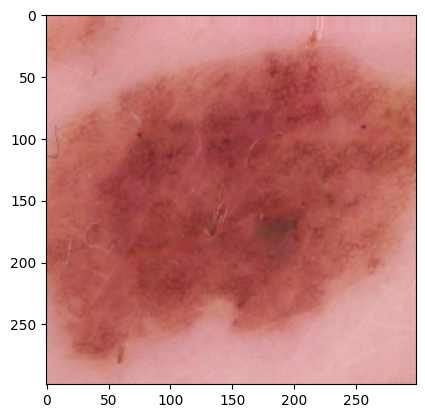

In [10]:
plt.imshow(train_image_gen[0][0][0]/255)

## Model Architecture: Transfer Learning with ConvNeXtSmall

### We leverage **ConvNeXtSmall**, a highly efficient and high-performing convolutional neural network, pretrained on ImageNet. The base is extended with a custom classification head tailored for the 7 skin lesion categories in the HAM10000 dataset.

In [11]:
base_model = ConvNeXtSmall(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable=True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1744908349.099114      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744908349.099767      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Model Summary: ConvNeXtSmall + Custom Classifier

In [12]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_prestem_n… │ (None, 299, 299, 3)    │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stem       │ (None, 74, 74, 96)     │          4,896 │ convnext_small_preste… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │          4,800 │ convnext_small_stem[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │            192 │ convnext_small_stage_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 384)    │         37,248 │ convnext_small_stage_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 384)    │              0 │ convnext_small_stage_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │         36,960 │ convnext_small_stage_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │             96 │ convnext_small_stage_… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │              0 │ convnext_small_stage_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 74, 74, 96)     │              0 │ convnext_small_stem[0… │
│                           │                        │                │ convnext_small_stage_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │          4,800 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_0_b… │ (None, 74, 74, 96)     │            192 │ convnext_small_stage_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_small_stage_

 Total params: 49,852,007 (190.17 MB)

 Trainable params: 49,852,007 (190.17 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation

In [13]:
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Callbacks for Efficient Training

In [14]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,mode='max', min_lr=0.00000001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce,early_stop]

## Training the Model

In [15]:
%%time
history = model.fit(train_image_gen,
                    epochs=30, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744908445.108887     122 service.cc:148] XLA service 0x7dcbc8003ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744908445.109831     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744908445.109852     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744908451.811568     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744908457.115557     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

149/267 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.2621 - loss: 7.8135

E0000 00:00:1744908783.794063     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744908783.927316     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3313 - loss: 7.4735

E0000 00:00:1744909082.113810     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744909082.249362     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.71915, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.3318 - loss: 7.4710 - val_accuracy: 0.7191 - val_loss: 5.3649 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6577 - loss: 5.2623
Epoch 2: val_accuracy improved from 0.71915 to 0.74983, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.6577 - loss: 5.2611 - val_accuracy: 0.7498 - val_loss: 4.2478 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7379 - loss: 3.9940
Epoch 3: val_accuracy improved from 0.74983 to 0.80053, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.7379 - loss: 3.9931 - val_accuracy: 0.8005 - val_loss: 3.3220 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7811 - loss: 3.0915
Epoch 4: val_accuracy improved from 0.8005

## Plotting Training and Validation Loss

<Axes: >

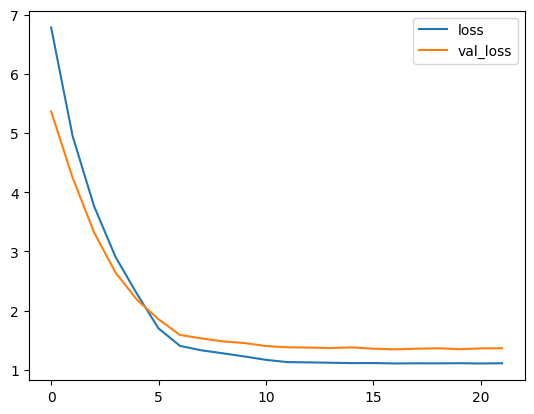

In [16]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

## Plotting Training and Validation Accuracy

<Axes: >

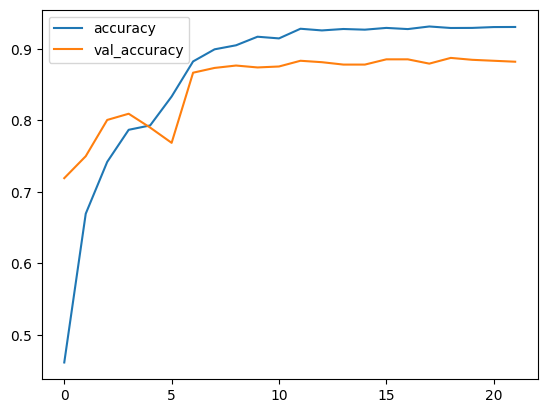

In [17]:
metrics[["accuracy","val_accuracy"]].plot()

## Model Evaluation

In [14]:
model.evaluate(test_image_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744975957.237501     112 service.cc:148] XLA service 0x7dbce00060c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744975957.238792     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744975957.238816     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744975957.962983     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744975960.638205     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8445 - loss: 1.5110

E0000 00:00:1744976000.557468     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744976000.693301     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 858ms/step - accuracy: 0.8460 - loss: 1.5051


[1.3703675270080566, 0.8812541961669922]

## Making Predictions and Evaluating Model Output

In [16]:
y_score = model.predict(test_image_gen, verbose=1)
predictions = y_score.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 873ms/step


## Confusion Matrix

In [17]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[ 38   6   2   0   1   2   0]
 [  1  71   0   0   1   4   0]
 [  5   0 135   1  12  11   0]
 [  1   0   0  16   0   0   0]
 [  2   3  17   0 119  23   2]
 [  0   6  22   3  45 929   0]
 [  0   0   0   0   1   0  20]]


## Normalized Confusion Matrix

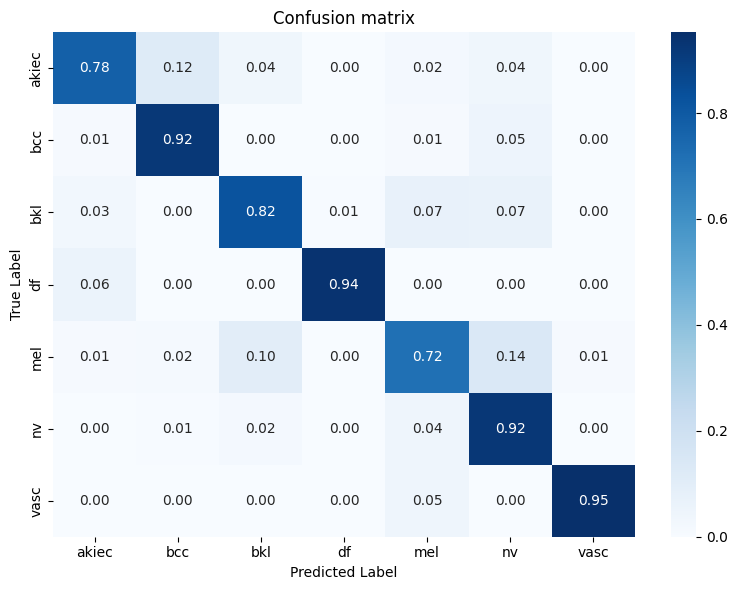

In [18]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes=list(test_image_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Classification Report

In [19]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        49
           1       0.83      0.92      0.87        77
           2       0.77      0.82      0.79       164
           3       0.80      0.94      0.86        17
           4       0.66      0.72      0.69       166
           5       0.96      0.92      0.94      1005
           6       0.91      0.95      0.93        21

    accuracy                           0.89      1499
   macro avg       0.82      0.87      0.84      1499
weighted avg       0.89      0.89      0.89      1499



## ROC AUC Score Calculation for Multi-class Classification

In [20]:
class_names = list(test_image_gen.class_indices.keys())
n_classes = len(class_names)

y_test_bin = label_binarize(test_labels, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    print(f"ROC AUC Score for Class {class_names[i]}: AUC = {roc_auc[i]:.4f}")

ROC AUC Score for Class akiec: AUC = 0.9871
ROC AUC Score for Class bcc: AUC = 0.9975
ROC AUC Score for Class bkl: AUC = 0.9756
ROC AUC Score for Class df: AUC = 0.9931
ROC AUC Score for Class mel: AUC = 0.9560
ROC AUC Score for Class nv: AUC = 0.9784
ROC AUC Score for Class vasc: AUC = 0.9997


## Plot ROC AUC  curves for all classes

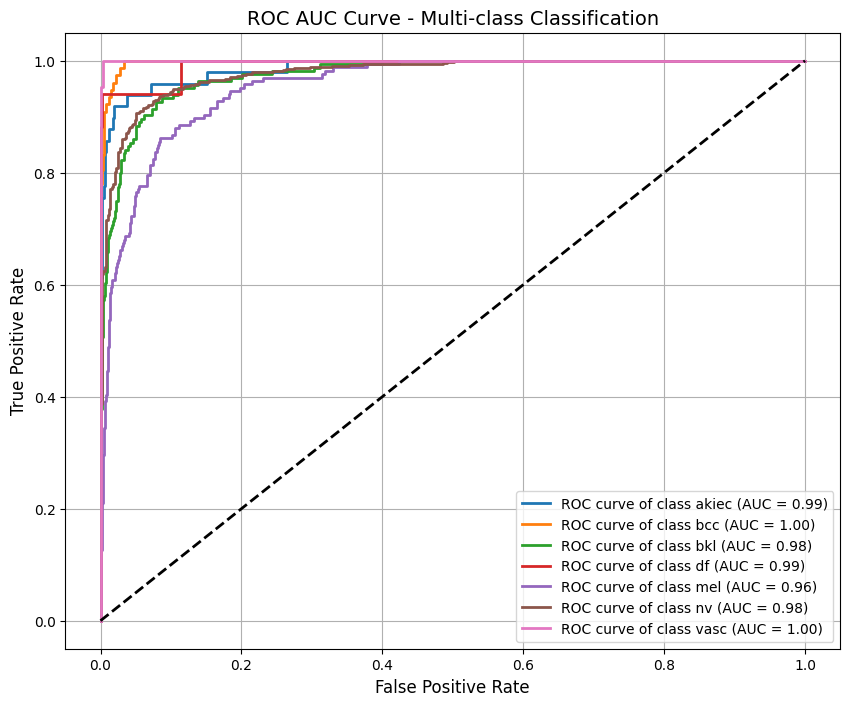

In [21]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC AUC Curve - Multi-class Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## Plot Precision-Recal curves for all classes

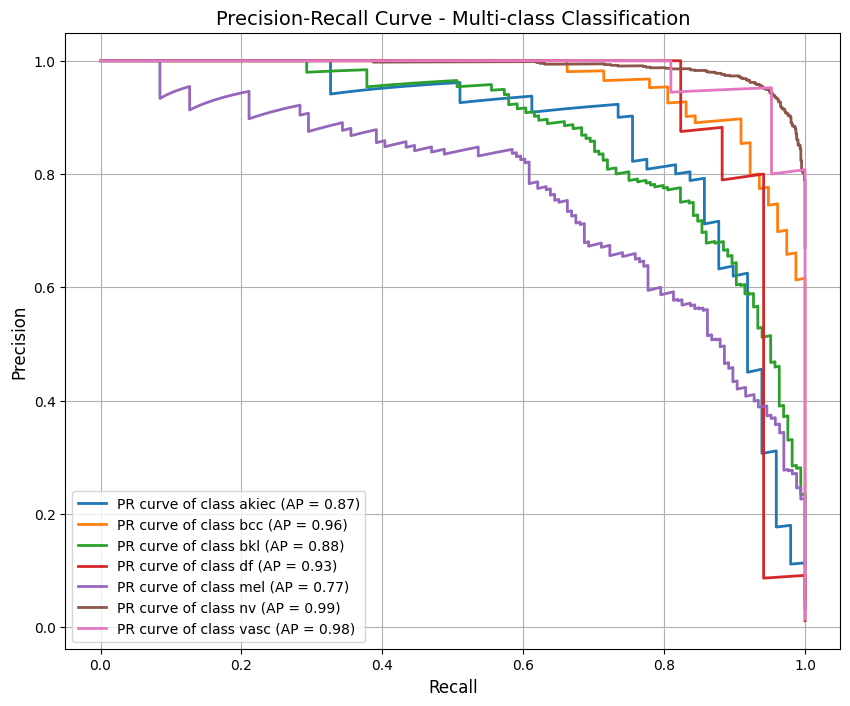

In [22]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Multi-class Classification", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()